In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

In [2]:
random_seed = 1
n_epochs = 3
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#global_mean = 0.1307 # MNIST train dataset mean
#global_std = 0.3081 # MNIST train dataset standard deviation

global_mean = 0.5 # MNIST train dataset mean
global_std = 0.5 # MNIST train dataset standard deviation

# Define a custom transform to flatten and reshape MNIST images to 784 (28x28)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((global_mean,), (global_std,)),
#     transforms.Lambda(lambda x: x.view(-1, 784))  # Reshape to (batch_size, 784)
# ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean,), (global_std,)),
])

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=True, download=True,
        transform=transform),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './mnst_files/', train=False, download=True,
        transform=transform),
    batch_size=batch_size_test, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


/tmp/ipykernel_41679/231131970.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


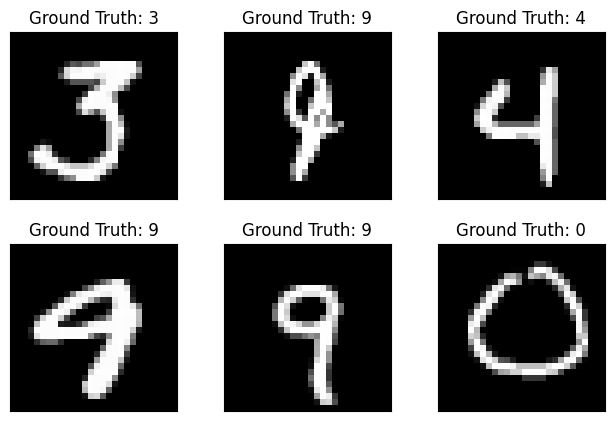

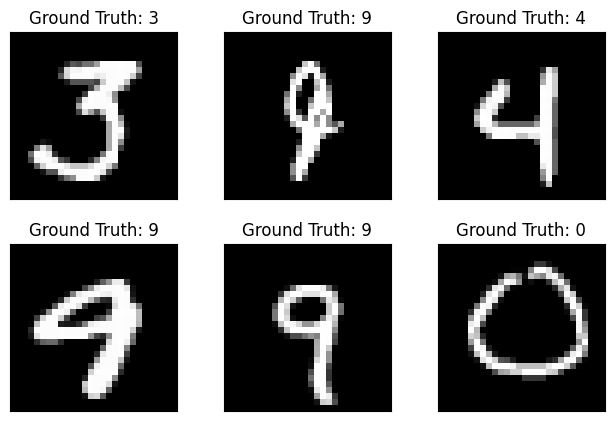

In [5]:
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Building the Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=784, n_classes=10, hidden_size=[128, 64]):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        #nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        #nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(hidden_size[1], n_classes)
        #nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Define training loop

In [11]:
# Training function
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        # Flatten the input images
        x = x.view(x.size(0), -1)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(train_loader)

    return loss_total, accuracy

# Validation function
def validate(model, data_loader, loss_fn, device):
    model.eval()
    loss_total = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Flatten the input images
            x = x.view(x.size(0), -1)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss_total += loss.item()
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total /= len(data_loader)

    return loss_total, accuracy

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Flatten the input images
            x = x.view(x.size(0), -1)
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    return torch.cat(predictions), accuracy


def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            # Flatten the input images
            x = x.view(x.size(0), -1)
            y_hat = model(x)
            _, predicted = y_hat.max(1)
            predictions.append(predicted)

    return torch.cat(predictions)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model_weights = None

    def early_stop(self, validation_loss, model):
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [15]:
# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss function, and optimizer
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.8, weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    # Training
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"[{epoch+1}/{n_epochs}] Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")

    # Validation
    val_loss, val_acc = validate(model, test_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'[{epoch+1}/{n_epochs}] Val loss: {val_loss:.4f} acc: {val_acc:.2f}%')

    if early_stopper.early_stop(val_loss, model):
        early_stopper.save_best_weights(model)
early_stopper.restore_best_weights(model)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

[1/100] Train loss: 0.7241 acc: 80.57%


Training Progress:   1%|          | 1/100 [00:12<21:15, 12.88s/it]

[1/100] Val loss: 0.3493 acc: 89.66%
[2/100] Train loss: 0.3176 acc: 90.68%


Training Progress:   2%|▏         | 2/100 [00:25<21:08, 12.94s/it]

[2/100] Val loss: 0.2780 acc: 92.04%
[3/100] Train loss: 0.2631 acc: 92.28%


Training Progress:   3%|▎         | 3/100 [00:38<20:59, 12.99s/it]

[3/100] Val loss: 0.2342 acc: 93.17%
[4/100] Train loss: 0.2237 acc: 93.42%


Training Progress:   4%|▍         | 4/100 [00:51<20:48, 13.01s/it]

[4/100] Val loss: 0.2063 acc: 93.93%
[5/100] Train loss: 0.1918 acc: 94.38%


Training Progress:   5%|▌         | 5/100 [01:05<20:38, 13.04s/it]

[5/100] Val loss: 0.1825 acc: 94.58%
[6/100] Train loss: 0.1663 acc: 95.12%


Training Progress:   6%|▌         | 6/100 [01:17<20:22, 13.01s/it]

[6/100] Val loss: 0.1623 acc: 95.19%
[7/100] Train loss: 0.1471 acc: 95.73%


Training Progress:   7%|▋         | 7/100 [01:30<20:09, 13.00s/it]

[7/100] Val loss: 0.1398 acc: 95.75%
[8/100] Train loss: 0.1319 acc: 96.15%


Training Progress:   8%|▊         | 8/100 [01:43<19:51, 12.96s/it]

[8/100] Val loss: 0.1327 acc: 95.91%
[9/100] Train loss: 0.1189 acc: 96.52%


Training Progress:   9%|▉         | 9/100 [01:56<19:35, 12.92s/it]

[9/100] Val loss: 0.1268 acc: 96.22%
[10/100] Train loss: 0.1086 acc: 96.82%


Training Progress:  10%|█         | 10/100 [02:09<19:20, 12.89s/it]

[10/100] Val loss: 0.1142 acc: 96.61%
[11/100] Train loss: 0.0999 acc: 97.09%


Training Progress:  11%|█         | 11/100 [02:22<19:08, 12.91s/it]

[11/100] Val loss: 0.1165 acc: 96.56%
[12/100] Train loss: 0.0919 acc: 97.30%


Training Progress:  12%|█▏        | 12/100 [02:35<19:00, 12.96s/it]

[12/100] Val loss: 0.1043 acc: 96.92%
[13/100] Train loss: 0.0850 acc: 97.52%


Training Progress:  13%|█▎        | 13/100 [02:49<19:17, 13.31s/it]

[13/100] Val loss: 0.0955 acc: 97.19%
[14/100] Train loss: 0.0788 acc: 97.73%


Training Progress:  14%|█▍        | 14/100 [03:03<19:10, 13.38s/it]

[14/100] Val loss: 0.1007 acc: 96.94%
[15/100] Train loss: 0.0732 acc: 97.84%


Training Progress:  15%|█▌        | 15/100 [03:16<18:44, 13.23s/it]

[15/100] Val loss: 0.1033 acc: 96.83%
[16/100] Train loss: 0.0681 acc: 98.04%


Training Progress:  16%|█▌        | 16/100 [03:28<18:21, 13.12s/it]

[16/100] Val loss: 0.0873 acc: 97.37%
[17/100] Train loss: 0.0640 acc: 98.17%


Training Progress:  17%|█▋        | 17/100 [03:41<18:01, 13.03s/it]

[17/100] Val loss: 0.0834 acc: 97.48%
[18/100] Train loss: 0.0599 acc: 98.27%


Training Progress:  18%|█▊        | 18/100 [03:54<17:44, 12.98s/it]

[18/100] Val loss: 0.0919 acc: 97.26%
[19/100] Train loss: 0.0562 acc: 98.37%


Training Progress:  19%|█▉        | 19/100 [04:07<17:27, 12.94s/it]

[19/100] Val loss: 0.0838 acc: 97.37%
[20/100] Train loss: 0.0531 acc: 98.46%


Training Progress:  20%|██        | 20/100 [04:20<17:14, 12.93s/it]

[20/100] Val loss: 0.0833 acc: 97.47%
[21/100] Train loss: 0.0499 acc: 98.55%


Training Progress:  21%|██        | 21/100 [04:33<16:58, 12.89s/it]

[21/100] Val loss: 0.0793 acc: 97.49%
[22/100] Train loss: 0.0471 acc: 98.63%


Training Progress:  22%|██▏       | 22/100 [04:45<16:42, 12.85s/it]

[22/100] Val loss: 0.0838 acc: 97.54%
[23/100] Train loss: 0.0454 acc: 98.64%


Training Progress:  23%|██▎       | 23/100 [04:59<16:36, 12.95s/it]

[23/100] Val loss: 0.0800 acc: 97.61%
[24/100] Train loss: 0.0421 acc: 98.77%


Training Progress:  24%|██▍       | 24/100 [05:12<16:26, 12.98s/it]

[24/100] Val loss: 0.0834 acc: 97.45%
[25/100] Train loss: 0.0396 acc: 98.86%


Training Progress:  25%|██▌       | 25/100 [05:25<16:12, 12.97s/it]

[25/100] Val loss: 0.0760 acc: 97.75%
[26/100] Train loss: 0.0377 acc: 98.92%


Training Progress:  26%|██▌       | 26/100 [05:37<15:55, 12.92s/it]

[26/100] Val loss: 0.0806 acc: 97.68%
[27/100] Train loss: 0.0353 acc: 99.05%


Training Progress:  27%|██▋       | 27/100 [05:50<15:38, 12.86s/it]

[27/100] Val loss: 0.0735 acc: 97.77%
[28/100] Train loss: 0.0337 acc: 99.05%


Training Progress:  28%|██▊       | 28/100 [06:03<15:29, 12.91s/it]

[28/100] Val loss: 0.0728 acc: 97.72%
[29/100] Train loss: 0.0321 acc: 99.03%


Training Progress:  29%|██▉       | 29/100 [06:16<15:17, 12.92s/it]

[29/100] Val loss: 0.0770 acc: 97.70%
[30/100] Train loss: 0.0305 acc: 99.14%


Training Progress:  30%|███       | 30/100 [06:29<15:04, 12.92s/it]

[30/100] Val loss: 0.0754 acc: 97.83%
[31/100] Train loss: 0.0284 acc: 99.21%


Training Progress:  31%|███       | 31/100 [06:42<14:47, 12.86s/it]

[31/100] Val loss: 0.0771 acc: 97.65%
[32/100] Train loss: 0.0273 acc: 99.19%


Training Progress:  32%|███▏      | 32/100 [06:54<14:32, 12.83s/it]

[32/100] Val loss: 0.0707 acc: 97.84%
[33/100] Train loss: 0.0255 acc: 99.33%


Training Progress:  33%|███▎      | 33/100 [07:07<14:16, 12.79s/it]

[33/100] Val loss: 0.0765 acc: 97.75%
[34/100] Train loss: 0.0244 acc: 99.34%


Training Progress:  34%|███▍      | 34/100 [07:20<14:02, 12.76s/it]

[34/100] Val loss: 0.0726 acc: 97.72%
[35/100] Train loss: 0.0231 acc: 99.36%


Training Progress:  35%|███▌      | 35/100 [07:33<13:48, 12.75s/it]

[35/100] Val loss: 0.0722 acc: 97.79%
[36/100] Train loss: 0.0216 acc: 99.41%


Training Progress:  36%|███▌      | 36/100 [07:45<13:34, 12.73s/it]

[36/100] Val loss: 0.0735 acc: 97.73%
[37/100] Train loss: 0.0206 acc: 99.44%


Training Progress:  37%|███▋      | 37/100 [07:58<13:20, 12.71s/it]

[37/100] Val loss: 0.0739 acc: 97.80%
[38/100] Train loss: 0.0190 acc: 99.53%


Training Progress:  38%|███▊      | 38/100 [08:11<13:09, 12.74s/it]

[38/100] Val loss: 0.0750 acc: 97.70%
[39/100] Train loss: 0.0182 acc: 99.56%


Training Progress:  39%|███▉      | 39/100 [08:24<12:59, 12.78s/it]

[39/100] Val loss: 0.0806 acc: 97.65%
[40/100] Train loss: 0.0167 acc: 99.61%


Training Progress:  40%|████      | 40/100 [08:37<12:49, 12.82s/it]

[40/100] Val loss: 0.0782 acc: 97.78%
[41/100] Train loss: 0.0166 acc: 99.58%


Training Progress:  41%|████      | 41/100 [08:49<12:37, 12.84s/it]

[41/100] Val loss: 0.0921 acc: 97.38%
[42/100] Train loss: 0.0160 acc: 99.62%


Training Progress:  42%|████▏     | 42/100 [09:02<12:25, 12.85s/it]

[42/100] Val loss: 0.0744 acc: 97.78%
[43/100] Train loss: 0.0146 acc: 99.67%


Training Progress:  43%|████▎     | 43/100 [09:15<12:08, 12.78s/it]

[43/100] Val loss: 0.0762 acc: 97.83%
[44/100] Train loss: 0.0135 acc: 99.71%


Training Progress:  44%|████▍     | 44/100 [09:28<11:55, 12.78s/it]

[44/100] Val loss: 0.0778 acc: 97.77%
[45/100] Train loss: 0.0130 acc: 99.72%


Training Progress:  45%|████▌     | 45/100 [09:41<11:45, 12.83s/it]

[45/100] Val loss: 0.0757 acc: 97.80%
[46/100] Train loss: 0.0129 acc: 99.72%


Training Progress:  46%|████▌     | 46/100 [09:54<11:34, 12.87s/it]

[46/100] Val loss: 0.0720 acc: 97.93%
[47/100] Train loss: 0.0116 acc: 99.78%


Training Progress:  47%|████▋     | 47/100 [10:07<11:22, 12.88s/it]

[47/100] Val loss: 0.0822 acc: 97.81%
[48/100] Train loss: 0.0113 acc: 99.77%


Training Progress:  48%|████▊     | 48/100 [10:19<11:09, 12.88s/it]

[48/100] Val loss: 0.0782 acc: 97.85%
[49/100] Train loss: 0.0105 acc: 99.81%


Training Progress:  49%|████▉     | 49/100 [10:33<11:08, 13.11s/it]

[49/100] Val loss: 0.0776 acc: 97.87%
[50/100] Train loss: 0.0098 acc: 99.82%


Training Progress:  50%|█████     | 50/100 [10:46<10:54, 13.09s/it]

[50/100] Val loss: 0.0777 acc: 97.87%
[51/100] Train loss: 0.0091 acc: 99.86%


Training Progress:  51%|█████     | 51/100 [10:59<10:33, 12.93s/it]

[51/100] Val loss: 0.0758 acc: 97.91%
[52/100] Train loss: 0.0088 acc: 99.85%


Training Progress:  52%|█████▏    | 52/100 [11:11<10:16, 12.83s/it]

[52/100] Val loss: 0.0763 acc: 97.92%
[53/100] Train loss: 0.0083 acc: 99.86%


Training Progress:  53%|█████▎    | 53/100 [11:24<10:00, 12.78s/it]

[53/100] Val loss: 0.0809 acc: 97.85%
[54/100] Train loss: 0.0081 acc: 99.85%


Training Progress:  54%|█████▍    | 54/100 [11:37<09:47, 12.76s/it]

[54/100] Val loss: 0.0778 acc: 97.96%
[55/100] Train loss: 0.0074 acc: 99.89%


Training Progress:  55%|█████▌    | 55/100 [11:49<09:33, 12.75s/it]

[55/100] Val loss: 0.0763 acc: 98.02%
[56/100] Train loss: 0.0071 acc: 99.90%


Training Progress:  56%|█████▌    | 56/100 [12:02<09:22, 12.79s/it]

[56/100] Val loss: 0.0797 acc: 97.76%
[57/100] Train loss: 0.0066 acc: 99.91%


Training Progress:  57%|█████▋    | 57/100 [12:15<09:09, 12.78s/it]

[57/100] Val loss: 0.0775 acc: 97.89%
[58/100] Train loss: 0.0063 acc: 99.91%


Training Progress:  58%|█████▊    | 58/100 [12:28<08:59, 12.84s/it]

[58/100] Val loss: 0.0795 acc: 97.96%
[59/100] Train loss: 0.0059 acc: 99.93%


Training Progress:  59%|█████▉    | 59/100 [12:41<08:45, 12.83s/it]

[59/100] Val loss: 0.0829 acc: 97.86%
[60/100] Train loss: 0.0056 acc: 99.94%


Training Progress:  60%|██████    | 60/100 [12:54<08:33, 12.84s/it]

[60/100] Val loss: 0.0787 acc: 97.91%
[61/100] Train loss: 0.0051 acc: 99.94%


Training Progress:  61%|██████    | 61/100 [13:06<08:19, 12.81s/it]

[61/100] Val loss: 0.0782 acc: 97.89%
[62/100] Train loss: 0.0048 acc: 99.96%


Training Progress:  62%|██████▏   | 62/100 [13:19<08:07, 12.84s/it]

[62/100] Val loss: 0.0784 acc: 98.00%
[63/100] Train loss: 0.0047 acc: 99.95%


Training Progress:  63%|██████▎   | 63/100 [13:32<07:56, 12.88s/it]

[63/100] Val loss: 0.0805 acc: 97.90%
[64/100] Train loss: 0.0047 acc: 99.95%


Training Progress:  64%|██████▍   | 64/100 [13:45<07:43, 12.89s/it]

[64/100] Val loss: 0.0778 acc: 97.95%
[65/100] Train loss: 0.0043 acc: 99.96%


Training Progress:  65%|██████▌   | 65/100 [13:58<07:30, 12.87s/it]

[65/100] Val loss: 0.0799 acc: 98.01%
[66/100] Train loss: 0.0039 acc: 99.98%


Training Progress:  66%|██████▌   | 66/100 [14:11<07:16, 12.85s/it]

[66/100] Val loss: 0.0807 acc: 97.89%
[67/100] Train loss: 0.0037 acc: 99.98%


Training Progress:  67%|██████▋   | 67/100 [14:24<07:03, 12.84s/it]

[67/100] Val loss: 0.0794 acc: 97.98%
[68/100] Train loss: 0.0036 acc: 99.98%


Training Progress:  68%|██████▊   | 68/100 [14:36<06:50, 12.82s/it]

[68/100] Val loss: 0.0805 acc: 97.96%
[69/100] Train loss: 0.0034 acc: 99.98%


Training Progress:  69%|██████▉   | 69/100 [14:49<06:38, 12.87s/it]

[69/100] Val loss: 0.0829 acc: 97.97%
[70/100] Train loss: 0.0033 acc: 99.98%


Training Progress:  70%|███████   | 70/100 [15:02<06:26, 12.89s/it]

[70/100] Val loss: 0.0820 acc: 97.88%
[71/100] Train loss: 0.0031 acc: 99.99%


Training Progress:  71%|███████   | 71/100 [15:15<06:15, 12.94s/it]

[71/100] Val loss: 0.0835 acc: 97.92%
[72/100] Train loss: 0.0031 acc: 99.98%


Training Progress:  72%|███████▏  | 72/100 [15:28<06:02, 12.94s/it]

[72/100] Val loss: 0.0820 acc: 97.95%
[73/100] Train loss: 0.0030 acc: 99.98%


Training Progress:  73%|███████▎  | 73/100 [15:41<05:47, 12.88s/it]

[73/100] Val loss: 0.0838 acc: 97.97%
[74/100] Train loss: 0.0028 acc: 99.99%


Training Progress:  74%|███████▍  | 74/100 [15:54<05:33, 12.83s/it]

[74/100] Val loss: 0.0859 acc: 97.92%
[75/100] Train loss: 0.0027 acc: 99.99%


Training Progress:  75%|███████▌  | 75/100 [16:07<05:22, 12.89s/it]

[75/100] Val loss: 0.0832 acc: 97.89%
[76/100] Train loss: 0.0026 acc: 99.99%


Training Progress:  76%|███████▌  | 76/100 [16:20<05:10, 12.92s/it]

[76/100] Val loss: 0.0824 acc: 97.99%
[77/100] Train loss: 0.0025 acc: 99.99%


Training Progress:  77%|███████▋  | 77/100 [16:33<04:57, 12.94s/it]

[77/100] Val loss: 0.0835 acc: 98.05%
[78/100] Train loss: 0.0024 acc: 99.99%


Training Progress:  78%|███████▊  | 78/100 [16:46<04:44, 12.95s/it]

[78/100] Val loss: 0.0844 acc: 97.99%
[79/100] Train loss: 0.0023 acc: 100.00%


Training Progress:  79%|███████▉  | 79/100 [16:59<04:31, 12.92s/it]

[79/100] Val loss: 0.0849 acc: 97.95%
[80/100] Train loss: 0.0022 acc: 100.00%


Training Progress:  80%|████████  | 80/100 [17:11<04:17, 12.90s/it]

[80/100] Val loss: 0.0849 acc: 97.91%
[81/100] Train loss: 0.0021 acc: 100.00%


Training Progress:  81%|████████  | 81/100 [17:25<04:06, 12.99s/it]

[81/100] Val loss: 0.0848 acc: 97.98%
[82/100] Train loss: 0.0020 acc: 100.00%


Training Progress:  82%|████████▏ | 82/100 [17:37<03:51, 12.85s/it]

[82/100] Val loss: 0.0840 acc: 97.93%
[83/100] Train loss: 0.0019 acc: 100.00%


Training Progress:  83%|████████▎ | 83/100 [17:50<03:37, 12.80s/it]

[83/100] Val loss: 0.0870 acc: 97.89%
[84/100] Train loss: 0.0020 acc: 99.99%


Training Progress:  84%|████████▍ | 84/100 [18:02<03:24, 12.76s/it]

[84/100] Val loss: 0.0877 acc: 97.93%
[85/100] Train loss: 0.0019 acc: 100.00%


Training Progress:  85%|████████▌ | 85/100 [18:15<03:10, 12.71s/it]

[85/100] Val loss: 0.0852 acc: 97.91%
[86/100] Train loss: 0.0018 acc: 100.00%


Training Progress:  86%|████████▌ | 86/100 [18:28<02:57, 12.70s/it]

[86/100] Val loss: 0.0858 acc: 97.97%
[87/100] Train loss: 0.0018 acc: 100.00%


Training Progress:  87%|████████▋ | 87/100 [18:41<02:45, 12.71s/it]

[87/100] Val loss: 0.0883 acc: 97.99%
[88/100] Train loss: 0.0018 acc: 100.00%


Training Progress:  88%|████████▊ | 88/100 [18:53<02:32, 12.70s/it]

[88/100] Val loss: 0.0879 acc: 97.90%
[89/100] Train loss: 0.0017 acc: 100.00%


Training Progress:  89%|████████▉ | 89/100 [19:06<02:20, 12.74s/it]

[89/100] Val loss: 0.0884 acc: 97.96%
[90/100] Train loss: 0.0017 acc: 100.00%


Training Progress:  90%|█████████ | 90/100 [19:19<02:06, 12.68s/it]

[90/100] Val loss: 0.0871 acc: 97.99%
[91/100] Train loss: 0.0016 acc: 100.00%


Training Progress:  91%|█████████ | 91/100 [19:31<01:53, 12.65s/it]

[91/100] Val loss: 0.0889 acc: 97.93%
[92/100] Train loss: 0.0015 acc: 100.00%


Training Progress:  92%|█████████▏| 92/100 [19:44<01:41, 12.74s/it]

[92/100] Val loss: 0.0887 acc: 97.99%
[93/100] Train loss: 0.0015 acc: 100.00%


Training Progress:  93%|█████████▎| 93/100 [19:57<01:29, 12.73s/it]

[93/100] Val loss: 0.0892 acc: 97.93%
[94/100] Train loss: 0.0015 acc: 100.00%


Training Progress:  94%|█████████▍| 94/100 [20:10<01:16, 12.76s/it]

[94/100] Val loss: 0.0878 acc: 97.97%
[95/100] Train loss: 0.0014 acc: 100.00%


Training Progress:  95%|█████████▌| 95/100 [20:23<01:04, 12.80s/it]

[95/100] Val loss: 0.0876 acc: 98.00%
[96/100] Train loss: 0.0014 acc: 100.00%


Training Progress:  96%|█████████▌| 96/100 [20:35<00:51, 12.80s/it]

[96/100] Val loss: 0.0915 acc: 97.91%
[97/100] Train loss: 0.0014 acc: 100.00%


Training Progress:  97%|█████████▋| 97/100 [20:48<00:38, 12.74s/it]

[97/100] Val loss: 0.0890 acc: 97.95%
[98/100] Train loss: 0.0013 acc: 100.00%


Training Progress:  98%|█████████▊| 98/100 [21:01<00:25, 12.79s/it]

[98/100] Val loss: 0.0916 acc: 97.95%
[99/100] Train loss: 0.0013 acc: 100.00%


Training Progress:  99%|█████████▉| 99/100 [21:13<00:12, 12.74s/it]

[99/100] Val loss: 0.0892 acc: 97.95%
[100/100] Train loss: 0.0013 acc: 100.00%


Training Progress: 100%|██████████| 100/100 [21:26<00:00, 12.87s/it]

[100/100] Val loss: 0.0887 acc: 97.94%


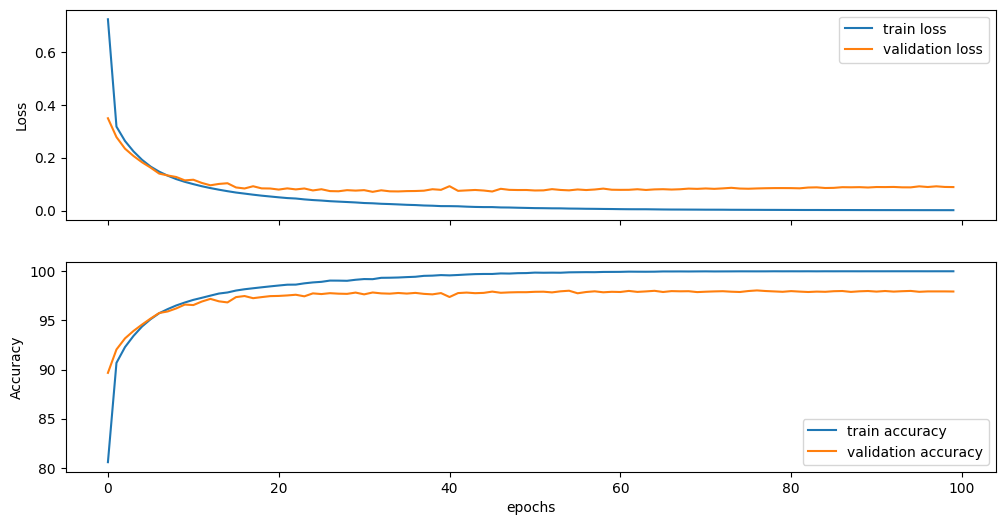

In [17]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

# Copy the tensors from GPU to CPU
train_loss_cpu = torch.Tensor(train_losses).cpu().tolist()
val_loss_cpu = torch.Tensor(val_losses).cpu().tolist()
train_acc_cpu = torch.Tensor(train_accuracies).cpu().tolist()
val_acc_cpu = torch.Tensor(val_accuracies).cpu().tolist()

ax1.plot(train_loss_cpu, label="train loss")
ax1.plot(val_loss_cpu, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_acc_cpu, label="train accuracy")
ax2.plot(val_acc_cpu, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()